In [1]:
import argparse

import torch

from accelerate import Accelerator, DeepSpeedPlugin

from accelerate import DistributedDataParallelKwargs

from torch import nn, optim

from torch.optim import lr_scheduler

from tqdm import tqdm



from models import Autoformer, DLinear, TimeLLM



#from data_provider.data_factory import data_provider

import time

import random

import numpy as np

import os



os.environ['CURL_CA_BUNDLE'] = ''

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"



from utils.tools import del_files, EarlyStopping, adjust_learning_rate, vali, load_content


fix_seed = 2021

random.seed(fix_seed)

torch.manual_seed(fix_seed)

np.random.seed(fix_seed)

/home/user/miniconda/envs/gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-05-28 14:22:45,099] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)

deepspeed_plugin = DeepSpeedPlugin(hf_ds_config='./ds_config_zero2.json')

accelerator = Accelerator(kwargs_handlers=[ddp_kwargs], deepspeed_plugin=deepspeed_plugin)

In [3]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from models import TimeLLM
from data_provider.data_factory import data_provider
import time
import torch

In [4]:
class Args:
    def __init__(self):
        self.task_name = 'long_term_forecast'
        self.is_training = 1
        self.model_id = 'Pretrain'
        self.model_comment = 'TimeLLM-Pretrain-13-2500'
        self.model = 'TimeLLM'
        self.seed = 2021
        self.data = 'few_shot_seq'
        self.root_path = './dataset'
        self.data_path = 'combined_dataframes-72.csv'
        self.features = 'MS'
        self.target = 'sold_units'
        self.loader = 'modal'
        self.freq = 'h'
        self.checkpoints = './checkpoints/'
        self.seq_len = 26
        self.label_len = 4
        self.pred_len = 4
        self.seasonal_patterns = 'Monthly'
        self.enc_in = 9
        self.dec_in = 9
        self.c_out = 9
        self.d_model = 32
        self.n_heads = 8  # Typically set by your model configuration
        self.e_layers = 2  # Typically set by your model configuration
        self.d_layers = 1  # Typically set by your model configuration
        self.d_ff = 128
        self.moving_avg = 25  # Assume default if not specified in the script
        self.factor = 3
        self.dropout = 0.1  # Assume default if not specified
        self.embed = 'timeF'  # Assume default if not specified
        self.activation = 'gelu'  # Assume default if not specified
        self.output_attention = False  # Assume default if not specified
        self.patch_len = 16  # Assume default if not specified
        self.stride = 8  # Assume default if not specified
        self.prompt_domain = 0  # Assume default if not specified
        self.llm_model = 'GPT2'
        self.llm_dim = 768
        self.num_workers = 10  # Default setting
        self.itr = 1
        self.train_epochs = 5
        self.align_epochs = 10  # Assume default if not specified
        self.batch_size = 1
        self.eval_batch_size = 1  # Assume default if not specified
        self.patience = 10  # Assume default if not specified
        self.learning_rate = 0.001
        self.des = 'Exp'
        self.loss = 'MSE'  # Assume default if not specified
        self.lradj = 'type1'  # Assume default if not specified
        self.pct_start = 0.2  # Assume default if not specified
        self.use_amp = False  # Assume default based on your environment capabilities
        self.llm_layers = 32
        self.percent = 100  # Assume default if not specified

# Instantiate the Args
args = Args()

In [5]:
combined_dataframes = pd.read_csv('./dataset/true_promo_data_77.csv')

In [6]:
path = 'checkpoints/Finetune/Finetune_350.pth'
# Load the checkpoint
model = TimeLLM.Model(args).float()
model.load_state_dict(torch.load(path), strict=False)

<All keys matched successfully>

In [7]:
from data_provider.data_loader import Dataset_few_shot_seq
from torch.utils.data import DataLoader

In [8]:
def data_provider(args, flag, data):
    
    timeenc = 0 if args.embed != 'timeF' else 1
    percent = args.percent

    if flag == 'test' or flag == 'few_shot': # zero shot not few shot
        shuffle_flag = False
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq

    data_set = Dataset_few_shot_seq(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq,
        percent=percent,
        seasonal_patterns=args.seasonal_patterns,
        df=data,
        scale = True
    )
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader

In [9]:
product_index = 1006

In [10]:
data = combined_dataframes[77*product_index:77*(product_index+1)].reset_index()

In [11]:
data.head()

,index,end_date,ean_global_channel,price_range,seasonality_index,sold_units,2 for a price,3 for 2,bogof,bogshp,coupon,listing fee,online,save,site fee
0,77462,2022-10-08,3600531369330_Offline,7.6,0.998335,216.0,0,0,0,0,0,0,1,1,1
1,77463,2022-10-15,3600531369330_Offline,7.6,1.017233,207.0,0,0,0,0,0,0,1,1,1
2,77464,2022-10-22,3600531369330_Offline,7.6,0.981129,234.0,0,0,0,0,0,0,1,1,1
3,77465,2022-10-29,3600531369330_Offline,7.6,1.025652,300.0,0,0,0,0,0,0,1,1,1
4,77466,2022-11-05,3600531369330_Offline,7.8,1.028782,234.0,0,0,0,0,0,0,1,1,1


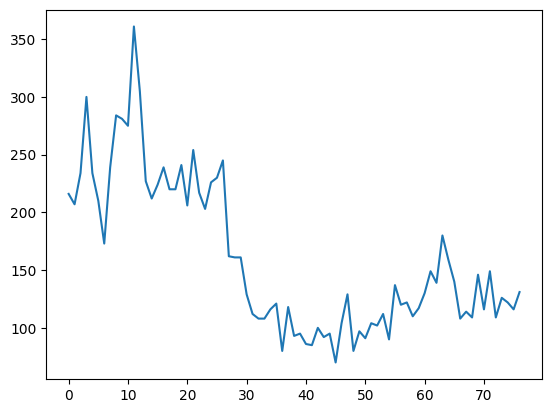

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(data["sold_units"])

In [13]:
train_data, train_loader = data_provider(args,'few_shot',data=data)

In [14]:
len(train_data)

144

In [15]:
train_data[0][0][0:6]

array([[-0.56638494],
       [-0.56638494],
       [-0.56638494],
       [-0.56638494],
       [-0.2211778 ],
       [-0.04857423]])

In [16]:
data['sold_units'].head(6)

0    216.0
1    207.0
2    234.0
3    300.0
4    234.0
5    210.0
Name: sold_units, dtype: float64

In [17]:
train_data, train_loader = data_provider(args, 'few_shot', data)

vali_data, vali_loader = data_provider(args, 'val', data)

test_data, test_loader = data_provider(args, 'test', data)



time_now = time.time()



train_steps = len(train_loader)

early_stopping = EarlyStopping(accelerator=accelerator, patience=args.patience)



trained_parameters = []

for p in model.parameters():

    if p.requires_grad is True:

        trained_parameters.append(p)



model_optim = optim.Adam(trained_parameters, lr=args.learning_rate)



if args.lradj == 'COS':

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model_optim, T_max=20, eta_min=1e-8)

else:

    scheduler = lr_scheduler.OneCycleLR(optimizer=model_optim,

                                        steps_per_epoch=train_steps,

                                        pct_start=args.pct_start,

                                        epochs=args.train_epochs,

                                        max_lr=args.learning_rate)



train_loader, vali_loader, test_loader, model, model_optim, scheduler = accelerator.prepare(

        train_loader, vali_loader, test_loader, model, model_optim, scheduler)

In [18]:
criterion = nn.MSELoss()
mae_metric = nn.L1Loss()

In [64]:
#variable_splits = np.split(np.array(y), 3, axis=0)

In [19]:
from torch.cuda.amp import autocast, GradScaler

# Setup scaler for managing precision
scaler = GradScaler()
MSE_loss = list()
MAE_loss = list()
predictions = list()
true_labels = list()
with torch.no_grad():  # No need to compute gradients during inference
    train_loss_mse = list()
    train_loss_mae = list()
    for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
        batch_x = batch_x.float().to(accelerator.device)
        batch_y = batch_y.float().to(accelerator.device)
        batch_x_mark = batch_x_mark.float().to(accelerator.device)
        batch_y_mark = batch_y_mark.float().to(accelerator.device)

        # Prepare decoder input as zeros initially, similar to training phase setup
        dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).to(accelerator.device)
        dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1)
        
        # Using autocast for automatic mixed precision
        with autocast():
            if args.output_attention:
                output, _ = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            else:
                output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

            output = output[:, -args.pred_len:, :]  # Adjust based on the output dimensions if needed
        loss = criterion(output, batch_y[:, -args.pred_len:, :])
        train_loss_mse.append(loss.item())
        loss = mae_metric(output, batch_y[:, -args.pred_len:, :])
        train_loss_mae.append(loss.item())
    
        predictions.append(output.cpu().numpy())
        true_labels.append(batch_y[:, -args.pred_len:, :].cpu().numpy())
    
# Convert list of arrays to a single numpy array
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
MAE_loss.append(np.average(train_loss_mae))
MSE_loss.append(np.average(train_loss_mse))


In [21]:
MAE_loss, MSE_loss

([0.6308653470542696], [0.7364448963457512])

In [67]:
true_labels.shape

(144, 4, 1)

In [68]:
predictions.shape

(144, 4, 1)

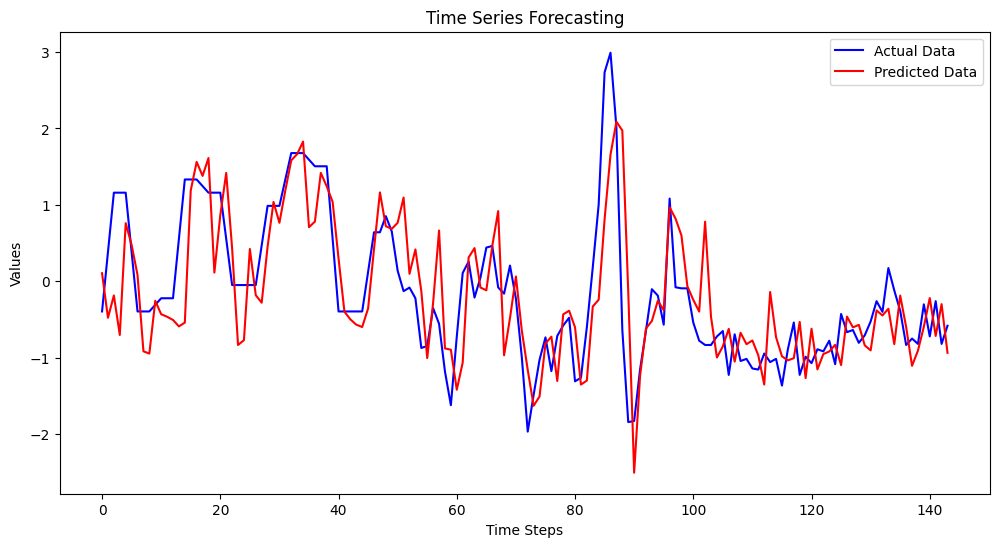

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
# Assuming predictions and true_labels are numpy arrays of the same shape
plt.figure(figsize=(12, 6))
plt.plot(true_labels[:, 0], label='Actual Data', color='blue')  # Adjust indexing based on your data shape
plt.plot(predictions[:, 0], label='Predicted Data', color='red')  # Adjust indexing based on your data shape
plt.title('Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

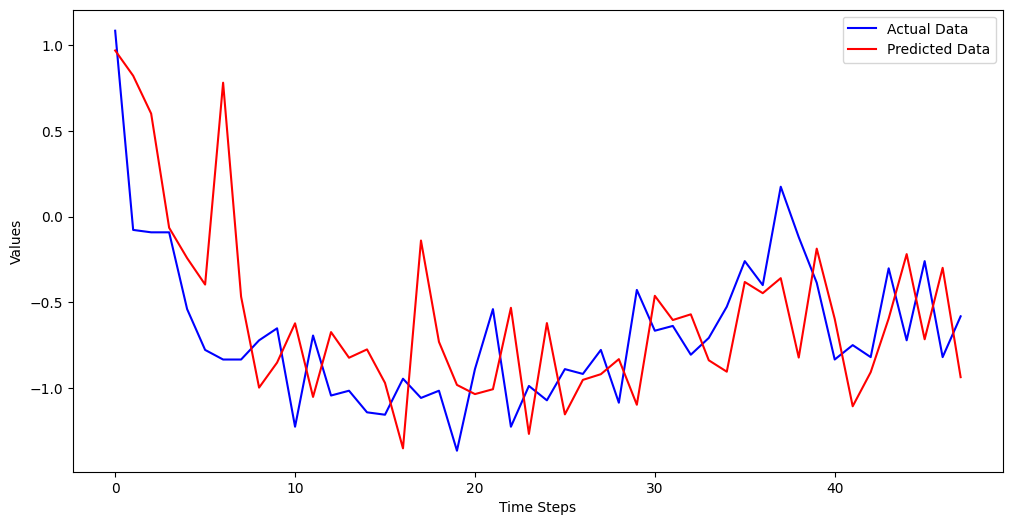

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
# Assuming predictions and true_labels are numpy arrays of the same shape
plt.figure(figsize=(12, 6))
plt.plot(true_labels[predictions.shape[0]//3*2:, 0], label='Actual Data', color='blue')  # Adjust indexing based on your data shape
plt.plot(predictions[predictions.shape[0]//3*2:, 0], label='Predicted Data', color='red')  # Adjust indexing based on your data shape

plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

# Scaling

In [ ]:
data

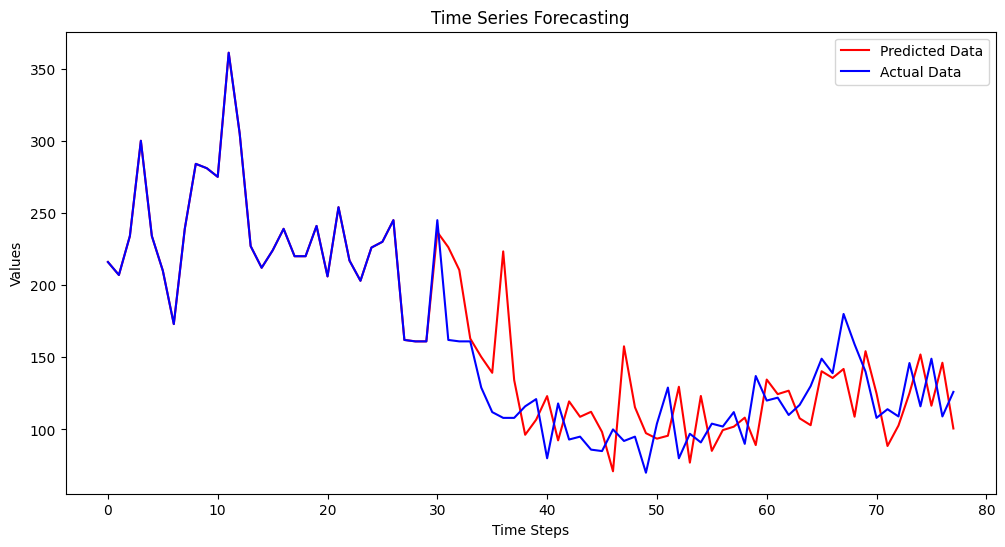

In [24]:
# Ensure numpy is imported: import numpy as np

# Reshape data to ensure compatibility for concatenation
actual_sales = data["sold_units"].iloc[:30].values.flatten()  # Converts to numpy array and flattens it

# Adjust true_labels and predictions by reshaping them if necessary
adjusted_true_labels = (true_labels[predictions.shape[0]//3*2:, 0] * train_data.std[2] + train_data.mean[2]).flatten()
adjusted_predictions = (predictions[predictions.shape[0]//3*2:, 0] * train_data.std[2] + train_data.mean[2]).flatten()

# Concatenate the adjusted data
actual_data = np.concatenate([actual_sales, adjusted_true_labels])
predicted_data = np.concatenate([actual_sales, adjusted_predictions])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predicted_data, label='Predicted Data', color='red')
plt.plot(actual_data, label='Actual Data', color='blue')
plt.title('Time Series Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()